In [1]:
pip install grad-cam opencv-python torch torchvision matplotlib


     ---------------------------------------- 7.8/7.8 MB 3.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 39.0/39.0 MB 3.4 MB/s eta 0:00:00
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44339 sha256=b5f7a9381db942ce91ed04266f2ebe076d9f08874faa3eca561fc6957358a9e7
  Stored in directory: c:\users\s k saxena\appdata\local\pip\cache\wheels\b2\92\f8\a0798503cc7de732e12a1a4bbf8a5469b57402a124ce95bfdc
Successfully built grad-cam
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstall

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\WebD\\Satellite_Property_Valuation\xa0\\venv\\Lib\\site-packages\\~umpy.libs\\libscipy_openblas64_-9e3e5a4229c1ca39f10dc82bba9e2b2b.dll'
Check the permissions.


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys, os
import pandas as pd
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models

# Add src folder to path
PROJECT_ROOT = os.path.abspath("..")
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

from extract_image_features import extract  # you already have this file


d:\WebD\Satellite_Property_Valuation \venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\WebD\Satellite_Property_Valuation \venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Load trained CNN model used for embeddings
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Grad-CAM setup
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def run_gradcam(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Could not load:", image_path)
        return None

    img = cv2.resize(img, (224, 224))
    img_rgb = img[..., ::-1]  # BGR → RGB
    img_rgb = img_rgb.astype(np.float32) / 255.0  # normalize for CAM overlay

    input_tensor = transform(img_rgb).unsqueeze(0).to(device)

    cam = GradCAM(model=resnet, target_layers=[resnet.layer4[-1]])
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    cam_overlay = show_cam_on_image(img_rgb, grayscale_cam)
    return cam_overlay


In [9]:
import os
train = pd.read_excel("../data/raw/train.xlsx")
def attach_images(df):
    df = df.copy()
    df["image_path"] = df["id"].astype(str).apply(
        lambda x: "../data/images/all/" + x + ".png"
    )
    return df

train = attach_images(train)

# optional check
print("Example paths:", train["image_path"].head(3).tolist())
print("Total rows:", len(train))
print("Images exist:", train["image_path"].apply(os.path.exists).sum())


Example paths: ['../data/images/all/9117000170.png', '../data/images/all/6700390210.png', '../data/images/all/7212660540.png']
Total rows: 16209
Images exist: 16209



Explaining: ../data/images/all/1853200190.png


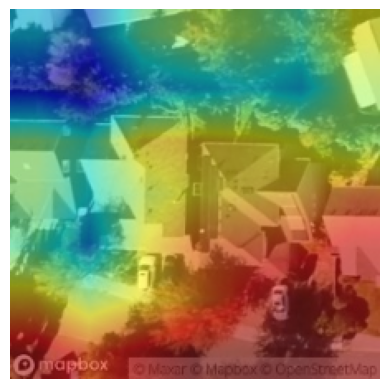


Explaining: ../data/images/all/121059147.png


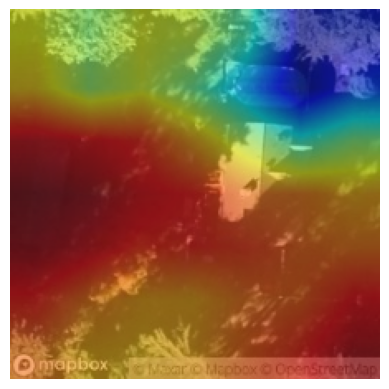


Explaining: ../data/images/all/123039176.png


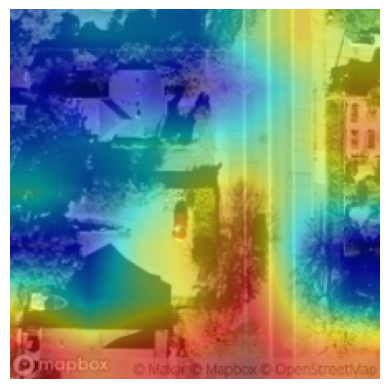


Explaining: ../data/images/all/1862400518.png


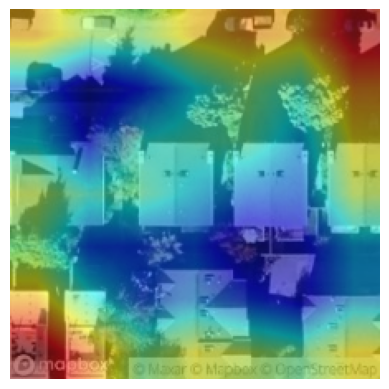


Explaining: ../data/images/all/3622059155.png


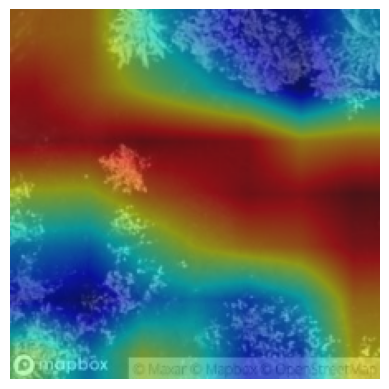

In [13]:
sample_paths = train["image_path"].dropna().sample(5, random_state=42).tolist()

for path in sample_paths:
    print("\nExplaining:", path)
    cam_img = run_gradcam(path)
    if cam_img is not None:
        plt.imshow(cam_img)
        plt.axis("off")
        plt.show()
